In [ ]:
! pip install pillow
! pip install numpy
! pip install matplotlib
! pip install scipy
! pip install opencv-python

In [1]:
from PIL import Image
from scipy import ndimage
from matplotlib import pyplot as plt
import numpy as np
import time
import cv2

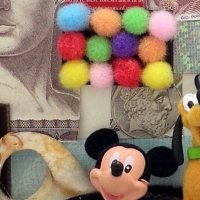

In [108]:
original = np.array(Image.open('Original.bmp'))
original_part = original[1300:1500, 1250:1450]
Image.fromarray(original_part)

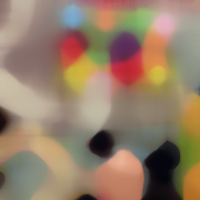

In [109]:
Image.fromarray(cv2.medianBlur(original_part, 2 * 15 + 1))

In [35]:
def pad(img, R):
    return cv2.copyMakeBorder(img, R, R,
               R, R, cv2.BORDER_REPLICATE)

### Простая сортировка

В данном алгоритме для каждого пикселя для каждого из каналов происходит поиск медианы по значению яркости в окне размером $(2R+1)\times(2R+1)$, что требует $O(R^2 \log R)$ времени в случае сортировки с использованием сравнения для поиска медианы, либо $O(R^2)$ времени в случае использования сортировки подсчетом или алгоритма поиска медианы за $O(n)$. Помимо памяти на хранение изображения и результата, требуется $O(R^2)$ доп. памяти на хранение и сортировку пикселей в окне

In [36]:
def naive_median_filter(img: np.array, R):
    h, w, _ = img.shape
    result = np.zeros_like(img)
    padded = pad(img, R)
    median_idx = (2 * R + 1) ** 2 // 2
    for i in range(R, h + R):
        for j in range(R, w + R):
            result[i - R][j - R] = np.sort(padded[i - R:i + R + 1, j - R:j + R + 1]
                                           .reshape(-1,3), axis=0)[median_idx]
            # result[i - R][j - R] = np.median(padded[i - R:i + R + 1, j - R:j + R + 1], axis=(0,1))
    return result        

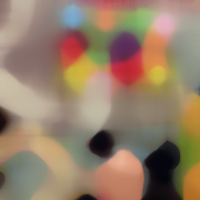

In [110]:
Image.fromarray(naive_median_filter(original_part, 15))

### Алгоритм Huang et al.
В данном алгоритме при движении окна вдоль каждой строки требуется $O(R)$ операций на пиксель на изменение гистограммы - добавить новый столбец высотой $2R+1$ и убрать старый. Также требуется $O(N)$ (здесь $N$ - количество уровней квантования) операций на обновление медианы - поиск нужной колонки в гистограмме из $N$ колонок. Инициализация гистограммы требует не более $O(R)$ операций на пиксель строки в случае, если к размер изображения считается с паддингом или размер фильтра хотя бы не сильно больше размера изображения, то есть во всех случаях применимости. Итоговая асимптотика по времени - $O(R + N)$. Помимо памяти на хранение изображения и результата, требуется $O(N)$ доп. памяти на хранение гистограммы (В реализации ниже требуется ещё $O(2(2R+1))$ памяти на копирование добавляемого и удаляемого столбцов, что необязательно, но в данном случае повышает читаемость кода)

In [93]:
class Hist:
    def __init__(self, window):
        self.R2p1 = window.shape[0]
        self.R = self.R2p1 // 2
        self.mdn_idx = self.R2p1 ** 2 // 2
        self.hist = np.zeros(256)
        
        for i in range(self.R2p1):
            for j in range(self.R2p1):
                self.hist[window[i][j]] += 1
                
        self.lt_mdn = 0
        self.mdn = 0
        self.upd_mdn()        
    
    def move_window(self, lmp_column: np.array, rm_column: np.array):
        for x in lmp_column:
            self.hist[x] -= 1
        for x in rm_column:
            self.hist[x] += 1
        self.lt_mdn += (rm_column < self.mdn).sum() - (lmp_column < self.mdn).sum()
        self.upd_mdn()
                
    def upd_mdn(self):
        if self.lt_mdn <= self.mdn_idx:
            while self.lt_mdn + self.hist[self.mdn] <= self.mdn_idx:
                self.lt_mdn += self.hist[self.mdn]
                self.mdn += 1
        else:        
            while self.lt_mdn > self.mdn_idx:
                self.mdn -= 1
                self.lt_mdn -= self.hist[self.mdn]
                
    def get_mdn(self):
        return self.mdn  
        
def huang_median_filter(img: np.array, R):
    h, w, channels = img.shape
    result = np.zeros_like(img)
    padded = pad(img, R)
    for c in range(channels):
        for i in range(R, h + R):
            hist = Hist(padded[i - R:i + R + 1, :2 * R + 1, c])
            result[i - R][0][c] = hist.get_mdn()
            for j in range(R + 1, w + R):
                lmp_column = padded[i - R:i + R + 1,j - R - 1, c].reshape(-1)
                rm_column = padded[i - R:i + R + 1,j + R, c].reshape(-1)
                hist.move_window(lmp_column, rm_column)
                result[i - R][j - R][c] = hist.get_mdn()
    return result            

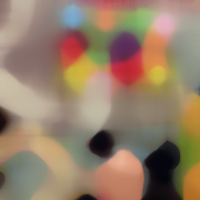

In [111]:
Image.fromarray(huang_median_filter(original_part, 15))

### Алгоритм constant time $O(1)$
В данном алгоритме  при движении окна вдоль каждой строки требуется $O(N)$ (здесь $N$ - количество уровней квантования) операций на пиксель для обновления гистограммы фильтра сложения с гистограммой добавляемого столбца и вычитания гистограммы удаляемого столбца. Также требуется $O(N)$ операций на поиск медианы по гистограмме. Также требуется $O(1)$ операций на пиксель при смещении по строкам - обновление гистограммы столбца путем добавления одного пикселя и удаления одного пикселя. Итоговая асимптотика по времени - $O(N)$. Помимо памяти на хранение изображения и результата, требуется  $𝑂(W*N)$ (здесь W - ширина или длина изображения) доп. памяти на хранение гистограммы фильтра и гистограмм для каждого из столбцов

In [ ]:
def build_hist(column: np.array):
    hist = np.zeros(256)
    for x in column:
        hist[x] += 1
    return hist

class Hists:
    def __init__(self, first_rows):
        self.R2p1 = first_rows.shape[0]
        self.R = self.R2p1 // 2
        self.mdn_idx = self.R2p1 ** 2 // 2
        
        self.hists = np.apply_along_axis(build_hist, 1, 
                        np.swapaxes(first_rows,0,1))
        self.init_H()
            
    def init_H(self):
        self.H = np.sum(self.hists[:self.R2p1], axis=0)
    
    def upd_column(self, j):
        lmp_hist = self.hists[j - self.R]
        rm_hist = self.hists[j + self.R + 1]
        self.H += rm_hist - lmp_hist
    
    def upd_row(self, ump_row, dm_row):
        for idx in range(self.hists.shape[0]):
            self.hists[idx][ump_row[idx]] -= 1
            self.hists[idx][dm_row[idx]] += 1
        self.init_H()
                
    def get_mdn(self):
        lt_mdn = 0
        mdn = 0
        if lt_mdn <= self.mdn_idx:
            while lt_mdn + self.H[mdn] <= self.mdn_idx:
                lt_mdn += self.H[mdn]
                mdn += 1
        else:        
            while lt_mdn > self.mdn_idx:
                mdn -= 1
                lt_mdn -= self.H[mdn]
        return mdn
            

def const_time_median_filter(img: np.array, R):
    h, w, channels = img.shape
    result = np.zeros_like(img)
    padded = pad(img, R)
    for c in range(channels):
        padded_ch = padded[:,:,c]
        hists = Hists(padded_ch[:2 * R + 1,:])
        for i in range(R, h + R):
            for j in range(R, w + R):
                result[i - R][j - R][c] = hists.get_mdn()
                if j != w + R - 1:
                    hists.upd_column(j)
            if i != h + R - 1:
                ump_row = padded_ch[i - R,:]
                dm_row = padded_ch[i + R + 1,:]
                hists.upd_row(ump_row, dm_row)
    return result                

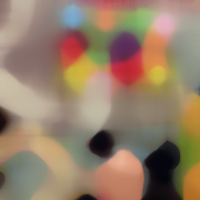

In [112]:
Image.fromarray(const_time_median_filter(original_part, 15))

### Проверка корректности

In [120]:
Rs = [1,2,5,10]

for R in Rs:
    for i in range(0, original.shape[0] - 1000, 1000):
        for j in range(0, original.shape[1] - 1000, 1000):
            part = original[i:i+200, j:j+200]
            opencv_result = cv2.medianBlur(part, 2 * R + 1)
            naive_result = naive_median_filter(part, R)
            huang_result = huang_median_filter(part, R)
            const_time_result = const_time_median_filter(part, R)
            assert np.allclose(opencv_result, naive_result)
            assert np.allclose(opencv_result, huang_result)
            assert np.allclose(opencv_result, const_time_result)
print("All assertions passed")            

All assertions passed


Все алгоритмы дают тот же результат, что и библиотечная реализация из OpenCV

### Время работы

Измерение времени работы алгоритмов будет проводиться для Full HD изображения

In [126]:
H = 1080
W = 1920
time_part = original[:H, :W]

In [127]:
def median_filter(img: np.array, R, algo='NAIVE'):
    if algo == 'NAIVE':
        return naive_median_filter(img, R)
    elif algo == 'HUANG':
        return huang_median_filter(img, R)
    elif algo == 'CONST TIME':
        return const_time_median_filter(img, R)
    elif algo == 'OPENCV':
        return cv2.medianBlur(img, 2 * R + 1)
    elif algo == 'COMBINED':
        # TODO
        pass
    else:
        # TODO
        pass

In [153]:
k = 10**6/(H*W)

Rs = [1, 5, 10, 20, 35, 45, 70, 99]
algos = ['NAIVE', 'HUANG', 'CONST TIME', 'OPENCV']
times = {}
for algo in algos:
    times[algo] = []

for R in Rs:
    print(f'Размер фильтра: {R}')
    print('Время работы:')
    for algo in algos:
        start_time = time.time()
        median_filter(time_part, R, algo)
        times[algo].append((time.time() - start_time) * k * 1000)
        print(f'    {algo:10}: {times[algo][-1]:.3f}')
    print('                мсек/мегапиксель')    
    print('------------------------------------')    

Радиус фильтра: 1
Время работы:
    NAIVE     : 4038.878
    HUANG     : 63537.647
    CONST TIME: 333716.089
    OPENCV    : 1.447
                мсек/мегапиксель
------------------------------------
Радиус фильтра: 5
Время работы:
    NAIVE     : 7281.585
    HUANG     : 78016.544
    CONST TIME: 334454.763
    OPENCV    : 107.932
                мсек/мегапиксель
------------------------------------
Радиус фильтра: 10
Время работы:
    NAIVE     : 20052.865
    HUANG     : 104844.989
    CONST TIME: 336869.193
    OPENCV    : 108.469
                мсек/мегапиксель
------------------------------------
Радиус фильтра: 20
Время работы:
    NAIVE     : 77993.820
    HUANG     : 158564.334
    CONST TIME: 352152.750
    OPENCV    : 115.835
                мсек/мегапиксель
------------------------------------
Радиус фильтра: 35
Время работы:
    NAIVE     : 245565.267
    HUANG     : 244629.324
    CONST TIME: 359875.802
    OPENCV    : 117.334
                мсек/мегапиксель
---------

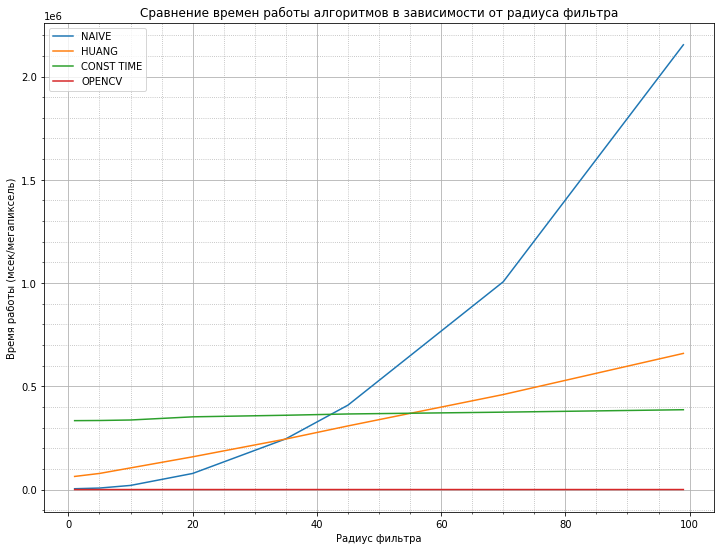

In [177]:
fig, ax = plt.subplots(figsize=(12,9))

for algo in algos:
    ax.plot(Rs, times[algo], label=algo)

ax.minorticks_on()
ax.grid(which='major')
ax.grid(which='minor', 
        linestyle = ':')
plt.title('Сравнение времен работы алгоритмов в зависимости от радиуса фильтра')
plt.xlabel('Радиус фильтра')
plt.ylabel('Время работы (мсек/мегапиксель)')
plt.legend()
plt.show()

In [200]:
lastR = Rs[-1]
k1 = times['NAIVE'][-1] / (lastR**2 * np.log(lastR))
k2 = times['HUANG'][-1] / lastR
asymptotics = [
    {'f': lambda R: k1 * R**2 * np.log(R), 'label': f"t = $k_1 \cdot R^2 log(R)$"},
    {'f': lambda R: k2 * R, 'label': "t = $k_2 \cdot R$"}
] 

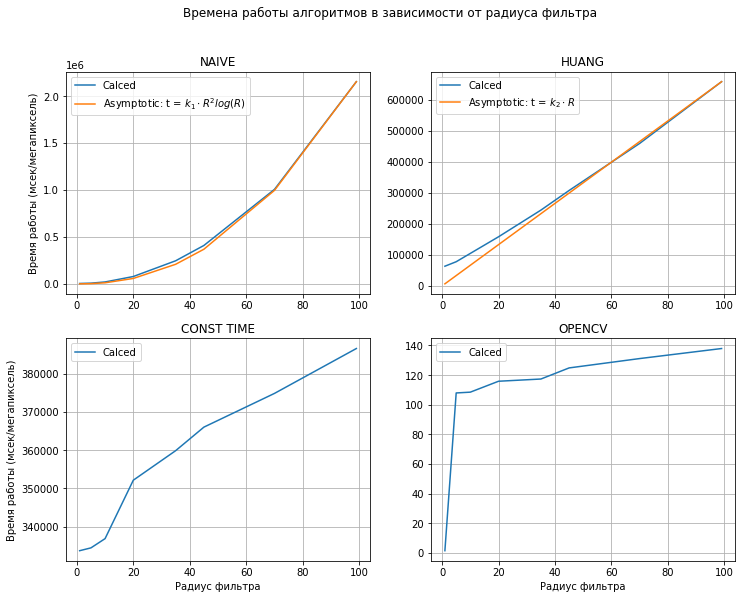

In [206]:
fig, axs = plt.subplots(2, 2, figsize=(12,9))

for i, algo in enumerate(algos):
    isSecondRow = i > 1
    isSecondColumn = i % 2 != 0
    ax = axs[int(isSecondRow), int(isSecondColumn)]
    ax.plot(Rs, times[algo], label='Calced')
    if (i < len(asymptotics)):
        ax.plot(Rs, list(map(asymptotics[i]['f'], Rs)), label='Asymptotic: ' + asymptotics[i]['label'])
    ax.grid()
    ax.legend()
    ax.set_title(algo)
    if isSecondRow:
        ax.set_xlabel('Радиус фильтра')
    if not isSecondColumn:
        ax.set_ylabel('Время работы (мсек/мегапиксель)')


fig.suptitle('Времена работы алгоритмов в зависимости от радиуса фильтра')
plt.show()    

Для алгоритма простой сортировки и алгоритма Huang et. al фактическое время работы в зависимости от радиуса фильтра согласуется с теоретической асимптотикой. Для алгоритма Сonstant time $O(1)$ заметно небольшое увеличение времени работы с увеличением радиуса фильтра. Это увеличение пренебрежимо мало по сравнению с увеличением времени работы алгоритма простой сортировки и алгоритма Huang et. al. Оно происходит, поскольку для фильтров большего размера требуется больший паддинг, и, соответственно, требуется обновлять больше гистограмм столбцов. Это увеличение укладывается в теоретическую оценку $O(1)$, если считать, что размер фильтра хотя бы не сильно больше размера изображения, то есть во всех случаях применимости.

### Параметры для оптимальной композиции алгоритмов

Из графика "Сравнение времен работы алгоритмов в зависимости от радиуса фильтра" можно предложить следующую оптимальную композицию реализованных алгоритмов:
- Для R < 35 использовать алгоритм простой сортировки
- Для 35 =< R < 55 использовать алгоритм Huang et. al
- Для R >= 55 использовать алгоритм Сonstant time $O(1)$